# The simulated data

## The acquisition geometry
- source-to-isocenter = 570
- source-to-detector = 1000
- 180 equi-angular projections from 0 to 179.

In this geometry, with the RTK convention, the source at angle 0 is in `(0,0,sid)` and at angle 90 deg in `(sid,0,0)`.

## The detector
- Detector size = 1200 x 300
- Pixel size = 1 mm
- Half fan angle = 31 degrees approx.

## The sample
The sample is a (standard, i.e. low-contrast) Shepp-Logan phantom, of size 40mm

The sample is located at 2 different positions in the two halves of the trajectory:
- `(141,42,0,141,42)` for the first half-scan (from 0 deg to 89 deg included).
- `(141,42,0,-141,42)` for the second half-scan (90 deg to 179 deg included)


Note on the whole simulated data: thoe object is very small (compared to a human e.g.) and the detector is very large. This is necessary if the object is to be **viewed** by all projections. In other words, the object being closer to the source position, it gets kicked out of the field-of-view quickly. This can be visualized on the animation in the cell below.
Move the cursors `aa` and `bb` to move source position in each half-scan.

In [40]:
%%html
<iframe scrolling="no" title="geometrie" src="https://www.geogebra.org/material/iframe/id/sheystqe/width/1949/height/952/border/888888/sfsb/true/smb/false/stb/false/stbh/false/ai/false/asb/false/sri/false/rc/true/ld/true/sdz/true/ctl/false" width="1949px" height="952px" style="border:0px;"> </iframe>

In [ ]:
import itk
from itk import RTK as rtk
import json
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider
%matplotlib widget


from dcc4cbct.fbcc import FBProblem, EpipolarPair
from dcc4cbct.misc import RecupParam
from dcc4cbct.rtk_utils import AddNoiseToProjections, ReadGeometryFile


In [2]:
# Load data
if not os.path.isfile("stack.mha"):
    result = subprocess.run(
        ["wget", "http://www.silx.org/pub/nabu/data/stack.mha"],
        capture_output=True,
        text=False
    )
    print(result.stdout)

interactive(children=(IntSlider(value=0, description='i', max=179), Output()), _dom_classes=('widget-interact'…

<function __main__.show_slice(i)>

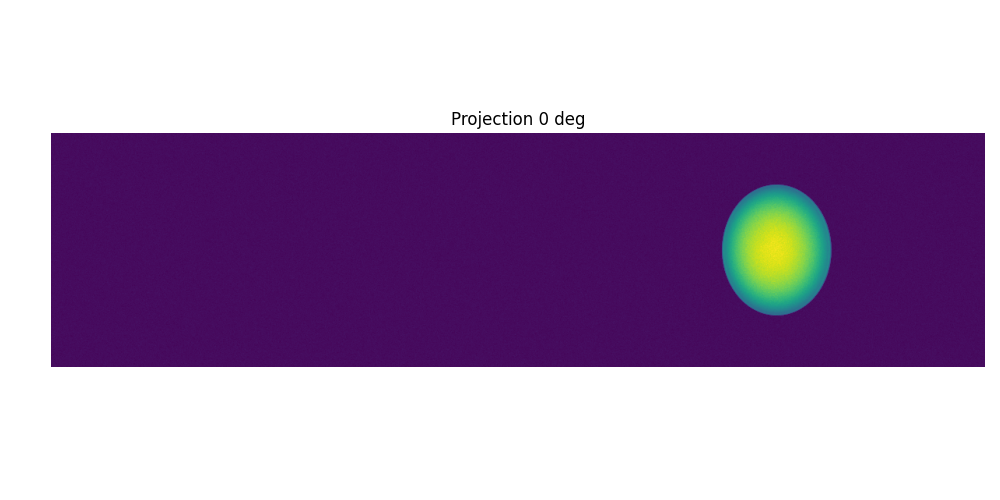

In [3]:

stack = itk.imread("stack.mha")
geo = ReadGeometryFile("geo.xml")


fig,ax = plt.subplots(figsize=(10,5))
im = ax.imshow(stack[0])
fig.tight_layout()
ax.set_title(f"Projection 0 deg")
ax.set_axis_off()


def show_slice(i):
    slice = stack[i]
    vmin = slice.min()
    vmax = slice.max()
    im.set_data(slice)
    im.set_clim(vmin, vmax)
    ax.set_title(f"Projection {i} deg")
    fig.canvas.draw_idle()


interact(show_slice, i=IntSlider(min=0,max=stack.shape[0]-1, step=1, value=0))

1

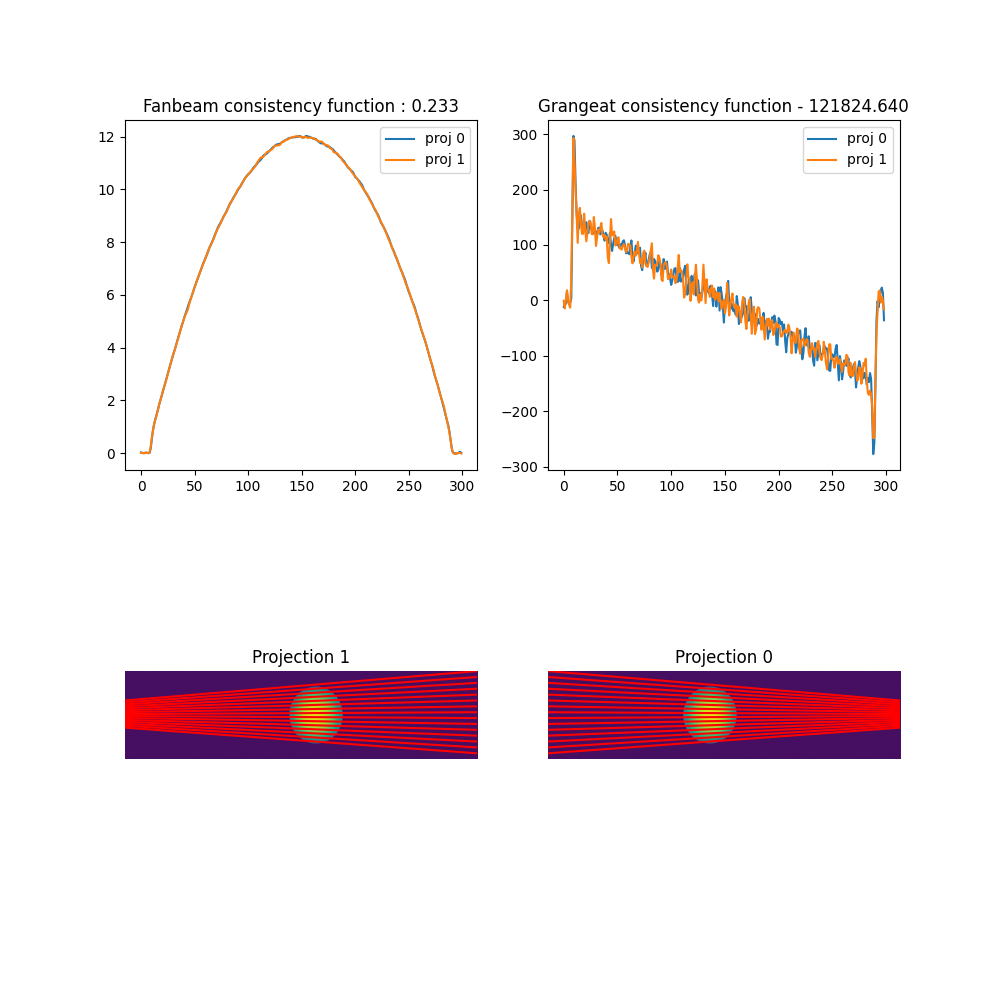

In [11]:
pb = FBProblem(geo, stack) 
pair = pb.create_pair([50, 130])
pair.analyze_pair(figsize=(10,10))


# Pair selection
In order to inform the selection of pairs, the consistency is computed for all pairs (i,j) where i in scan 1 (0-90 deg) and j in scan 2 (90-180 deg). The plots is shown below.
Depending on the epipolar geometry of each pair, some weird behavior may occur. Those pairs should be excluded. We mention there after two examples:

## Too large angular gaps
When both projection are almost opposite (e.g. (i,j)=(0,179)), the baseline intersects both detectors in their middle. The epipole could. lie inside the support of the projection. Since each projection pixel should be pre-weighted by the distance to the epipole, it could raise numerical issues. Those pairs are excluded.

To do so, we exclude all pairs such that the epipoles lies within the detector. It is easily seen that this happens iif the gap between both source positions is less than $(\pi - 2\times \text{half fan angle}) \approx 120 \text{deg}$.
See pair (0,189) above.

## Baseline parallel to the motion
In the figure below, the consistency is minimal along the i+j=90 (region delimited by yellow lines), which corresponds to all pairs for which the baseline is parallel to the motion. Those pairs are blind to the motion and should not be selected.

## Too small angular gaps
Another pathological case: the two source positions are very close from each other. This makes the abseline almost parallel to the detector planes, hence epipoles almost "at infinity": in other words, epipolar lines are almost parallel to the u-axis of the projections, in both projections. The DCC (beside numerical issues that may arise from the distance-to-epipole weighting) are then blind to horizontal motion of the sample. See pair (89,90) above. I excluded pairs whose angular gaps is less than 20 degrees.

In the figure below, the consistency maops are displayed. The two excluded regions are limited with red lines. One can see that the consistency is fairly homogeneous in the admissible region, while weird behaved in the 2 excluded regions.

In [5]:
import os
if os.path.isfile("cost_pre_corr.npz"):
    data = np.load("cost_pre_corr.npz")
    fb = data["fb"]
    gr = data["gr"]
else:
    fb = np.zeros((90,90),dtype=float)
    gr = np.zeros((90,90),dtype=float)
    def do_fb_work(i,j):
        print(i,j)
        pb = FBProblem(geo, stack)
        pair = pb.create_pair([i,j+90])
        fb[i,j] = pair.compute_fanbeam_consistency()
        gr[i,j] = pair.compute_grangeat_consistency()

    from concurrent.futures import ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=12) as executor:
        futures = []
        for i in range(90):
            for j in range(90):
                futures.append(executor.submit(do_fb_work, i, j))

        for future in futures:
            future.result()




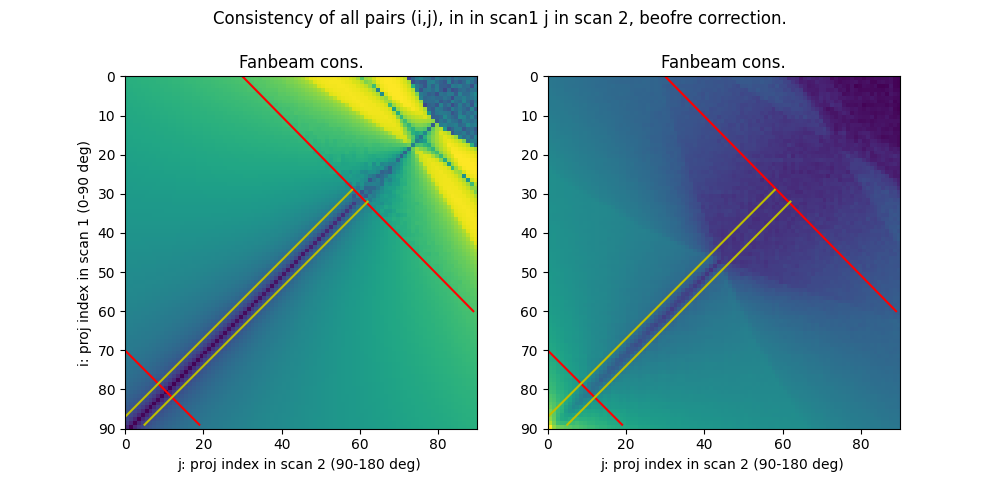

In [17]:
gridI, gridJ = np.meshgrid(np.arange(90),np.arange(90),indexing="ij")
mask1 = gridJ - gridI < 30
mask2 = gridI < gridJ + 70
fbmasked = (fb * mask1 * mask2).astype(float)
grmasked = (gr * mask1 * mask2).astype(float)

import matplotlib.colors as colors

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Consistency of all pairs (i,j), in in scan1 j in scan 2, beofre correction.")
ax[0].imshow(fb,norm=colors.LogNorm(),extent=(0,90,90,0))
ax[0].set_title("Fanbeam cons.")
ax[0].set_xlabel("j: proj index in scan 2 (90-180 deg) ")
ax[0].set_ylabel("i: proj index in scan 1 (0-90 deg)")
ax[0].plot((30,89),(0,60),'r')
ax[0].plot((0,19),(70,89),'r')
ax[0].plot((5,62),(89,32),"y")
ax[0].plot((0,58),(87,29),"y")
ax[1].imshow(gr, norm=colors.LogNorm(),extent=(0,90,90,0))
ax[1].plot((30,89),(0,60),'r')
ax[1].plot()
ax[1].set_title("Fanbeam cons.")
ax[1].set_xlabel("j: proj index in scan 2 (90-180 deg) ")
ax[1].plot((0,19),(70,89),'r')
ax[1].plot((5,62),(89,32),"y")
ax[1].plot((0,58),(87,29),"y")


# Selecting 2 pairs for minimization

I picked two pairs in the admissible regions (30,100) and (80,150).
The behavior of DCC cost functions is displayed in the following cell:

In [18]:
with open("sf_config.json","r") as f:
    config = json.load(f)

displacement_vector_x = config["phantom"]["translation_x_1"] - config["phantom"]["translation_x_2"]
displacement_vector_z = config["phantom"]["translation_z_1"] - config["phantom"]["translation_z_2"]
pairs_angles_1 = config["pairs"]["angle_1"]
pairs_angles_2 = config["pairs"]["angle_2"]


# Sc de ref (0,72) et (0,108). Toujours une vallee mais OK. Vallee 
pb = FBProblem(geo, stack)
pb.add_pair_to_problem([pairs_angles_1[0], pairs_angles_2[0]]) #0-72
pb.add_pair_to_problem([pairs_angles_1[1], pairs_angles_2[1]]) #0-108

tx = np.linspace(displacement_vector_x - 10, displacement_vector_x + 10, 21)
tz = np.linspace(displacement_vector_z - 10, displacement_vector_z + 10, 21)
X,Z = np.meshgrid(tx, tz)

if os.path.isfile("costs_2d.npz"):
    data = np.load("costs_2d.npz")
    cost_fb = data["fb"]
    cost_gr = data["gr"]
else:
    cost_fb = np.zeros_like(X)
    cost_gr = np.zeros_like(X)

    from concurrent.futures import ThreadPoolExecutor, as_completed
    from tqdm import tqdm

    def compute_consistencies(i, j, x, z):
        fb = 0.
        gr = 0.
        for pair in pb.pairs:
            g0 = pair.g0
            g1 = pair.g1
            p0 = pair.p0
            p1 = pair.p1
            sid,sdd,ga,dx,dy,oa,ia,sx,sy = RecupParam(g1,0)
            rotmat = np.array(g1.GetRotationMatrix(0))
            delta_dx, delta_dy, delta_sid, _ = np.dot(rotmat, np.array([x, 0, z, 0]))
            g1bis = rtk.ThreeDCircularProjectionGeometry.New()
            new_sid = sid + delta_sid
            new_dx = dx + delta_dx
            new_dy = dy + delta_dy
            new_sx = sx + delta_dx
            new_sy = sy + delta_dy
            g1bis = rtk.ThreeDCircularProjectionGeometry.New()
            g1bis.AddProjectionInRadians(new_sid, sdd, ga, new_dx, new_dy, oa, ia, new_sx, new_sy)
            pair = EpipolarPair(g0, g1bis, p0, p1)
            fb += pair.compute_fanbeam_consistency()
            gr += pair.compute_grangeat_consistency()
        return (i, j, fb, gr)

    futures = []
    with ThreadPoolExecutor() as executor:
        for i, x in enumerate(tx):
            for j, z in enumerate(tz):
                futures.append(executor.submit(compute_consistencies, i, j, x, z))

        for f in tqdm(as_completed(futures), total=len(futures), desc="Processing pairs"):
            i, j, fb, gr = f.result()
            cost_fb[i, j] = fb
            cost_gr[i, j] = gr 




Attempt to set non-positive zlim on a log-scaled axis will be ignored.


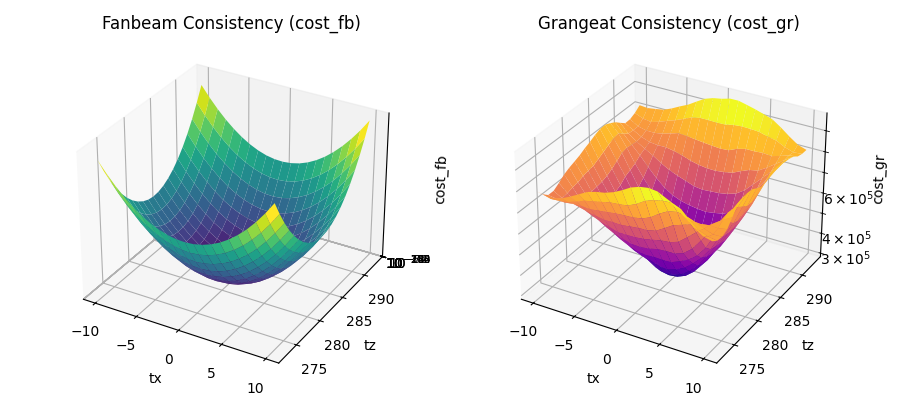

In [21]:
# Plotting the results
fig = plt.figure(figsize=(9,4))

# Plot cost_fb
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Z, cost_fb, cmap='viridis')
ax1.set_title('Fanbeam Consistency (cost_fb)')
ax1.set_xlabel('tx')
ax1.set_ylabel('tz')
ax1.set_zlabel('cost_fb')
ax1.set_zscale("log")

# Plot cost_gr
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Z, cost_gr, cmap='plasma')
ax2.set_title('Grangeat Consistency (cost_gr)')
ax2.set_xlabel('tx')
ax2.set_ylabel('tz')
ax2.set_zlabel('cost_gr')
ax2.set_zscale("log")

plt.tight_layout()
plt.show()


In [42]:
# Minimizing the cost function
from scipy.optimize import minimize

# Define both cost functions (fanbeam and Grangeat)

def cost_fun_fb(params, pb, verbose):
    x = params[0]
    z = params[1]
    fb = 0.
    for pair in pb.pairs:
        g0 = pair.g0
        g1 = pair.g1
        p0 = pair.p0
        p1 = pair.p1
        sid,sdd,ga,dx,dy,oa,ia,sx,sy = RecupParam(g1,0)
        rotmat = np.array(g1.GetRotationMatrix(0))
        delta_dx, delta_dy, delta_sid, _ = np.dot(rotmat, np.array([x, 0, z, 0]))
        g1bis = rtk.ThreeDCircularProjectionGeometry.New()
        new_sid = sid + delta_sid
        new_dx = dx + delta_dx
        new_dy = dy + delta_dy
        new_sx = sx + delta_dx
        new_sy = sy + delta_dy
        g1bis = rtk.ThreeDCircularProjectionGeometry.New()
        g1bis.AddProjectionInRadians(new_sid, sdd, ga, new_dx, new_dy, oa, ia, new_sx, new_sy)
        pair = EpipolarPair(g0, g1bis, p0, p1)
        fb += pair.compute_fanbeam_consistency()
    if verbose:
        print(f"Eval at ({x:.4f},{z:.4f}) \t:\t {fb:.4f}")
    return fb

def cost_fun_gr(params, pb, verbose):
    x = params[0]
    z = params[1]
    gr = 0.
    for pair in pb.pairs:
        g0 = pair.g0
        g1 = pair.g1
        p0 = pair.p0
        p1 = pair.p1
        sid,sdd,ga,dx,dy,oa,ia,sx,sy = RecupParam(g1,0)
        rotmat = np.array(g1.GetRotationMatrix(0))
        delta_dx, delta_dy, delta_sid, _ = np.dot(rotmat, np.array([x, 0, z, 0]))
        g1bis = rtk.ThreeDCircularProjectionGeometry.New()
        new_sid = sid + delta_sid
        new_dx = dx + delta_dx
        new_dy = dy + delta_dy
        new_sx = sx + delta_dx
        new_sy = sy + delta_dy
        g1bis = rtk.ThreeDCircularProjectionGeometry.New()
        g1bis.AddProjectionInRadians(new_sid, sdd, ga, new_dx, new_dy, oa, ia, new_sx, new_sy)
        pair = EpipolarPair(g0, g1bis, p0, p1)
        gr += pair.compute_grangeat_consistency()
    if verbose:
        print(f"Eval at ({x:.4f},{z:.4f}) \t:\t {gr:.4f}")
    return gr


In [49]:
pb = FBProblem(geo, stack)
pb.add_pair_to_problem([pairs_angles_1[0], pairs_angles_2[0]]) #0-72
pb.add_pair_to_problem([pairs_angles_1[1], pairs_angles_2[1]]) #0-108

verbose = False
sol = minimize(cost_fun_fb,(10,270),(pb,verbose),method="Powell")
print(sol)

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.8272172493527837
       x: [-5.642e-02  2.827e+02]
     nit: 3
   direc: [[ 1.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00]]
    nfev: 86


In [51]:
# Increase the number of pairs
pb = FBProblem(geo, stack)
pb.add_pair_to_problem([pairs_angles_1[0], pairs_angles_2[0]]) #0-72
pb.add_pair_to_problem([pairs_angles_1[1], pairs_angles_2[1]]) #0-108

pb.add_pair_to_problem((35,105))
pb.add_pair_to_problem((75,155))

verbose=False
sol = minimize(cost_fun_fb,(30,300),(pb,verbose),method="Powell")

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


In [52]:
sol

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.6909302193764755
       x: [-9.840e-04  2.827e+02]
     nit: 3
   direc: [[ 0.000e+00  1.000e+00]
           [-2.397e-02 -4.731e-03]]
    nfev: 123

# Find new consistent pair
The motion displacement is estimated by mimicking a translation of the gantry during scan 2 so that the projections of scan 2 are as if they were acquired with the sample in its scan-1 position.
By doing so, the new geometry (for which the whole stack of projections is consistent) is built by translating scan 2 in the direction of scan 1. Hence, both arcs of circle will intersect in some point: the corresponding projections should be exactly identical (because acquired from the same source position).
Let $(x0,z0)$ ($(0,282.84)$ in our simulation) be the displacement vector. The source position along scan-1 arc of circle is given by $(sid \cos \alpha, 0, sid \sin \alpha)$. The position along scan-2 is $(sid\cos \beta + x0,0,sid \sin \beta + z0)$. Both arcs interrsect if

$$
\begin{align}
sid \sin \alpha &= sid\sin \beta\\
sid \cos \alpha &= sid\cos \beta + z0
\end{align}
$$
Since $\beta \in [90,180]$, one has $\beta = \pi - \alpha$, which leads to leads to:

$$
\alpha = \arccos\left( \frac{z0}{2sid}\right) \approx 75.63 \degree
$$




1

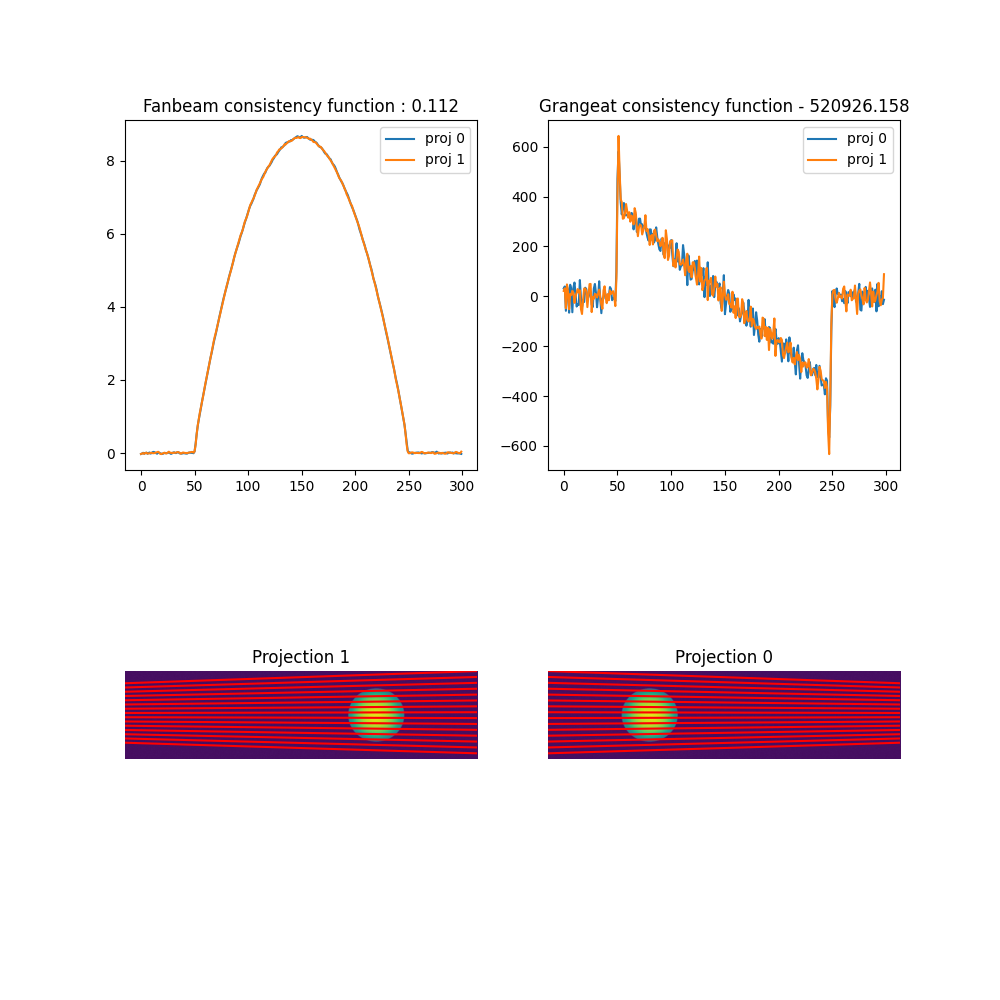

In [53]:
pair = pb.create_pair((75,105))
pair.analyze_pair()

THere must be something wrong in what I claimed in the previous cell (both projections should be equal). 